# Анализ клиентов банка (поиск инсайтов, составление рекомендаций стейкхолдерам, построение модели оттока клиентов)

Заказчик - международный европейский банк.

Цель - проанализировать клиентов банка и выявить какие характеристики влияют на отток пользователей, а также построить модель прогнозирования оттока пользователей.

Бизнес-задача -  выявить какие пользователи, подвержены оттоку, снизить отток и тем самым увеличить прибыль банка.


In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Шаг 1 - Изучение исходных данных из файла

In [ ]:
# чтение рабочего файла
bank = pd.read_csv('ChurnModeling.csv')
bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
bank.info() # общая информация: нет пропусков, типы данных указаны корректно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
bank = bank.drop_duplicates() # удаление дубликатов

bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Отчищаем данные от ненужной информации, в данном случае это столбцы, содержащие персональную информацию, т.к. нас интересуют группы людей.

In [ ]:
bank.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True) # удаление столбцов, содержащих персональную информацию

bank.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Вывод**

Данные нормализованы: они не содержат пустых значений (NaN, None), соблюдены типы данных для разных столбцов, а также нет дубликатов.

Данные подготовлены для дальнейшей работы.

# Шаг 2 - Предварительный анализ имеющихся данных

In [ ]:
bank['Geography'].unique() 

array(['France', 'Spain', 'Germany'], dtype=object)

Банк имеет филиалы во Франции, Испании, Германии.

In [ ]:
bank['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Наибольший охват у банка во Франции, т.к. там больше всего зарегистрированных клиентов.

In [ ]:
bank['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [ ]:
(5084+4590)/10000*100 # доля клиентов с 1-2 продуктами

96.74000000000001

In [ ]:
266/10000*100 # доля клиентов с 3 продуктами

2.6599999999999997

In [ ]:
60/10000*100 # доля клиентов с 4 продуктами

0.6

Продуктовая линейка банка состоит из 4-х банковских продуктов. 

Подавляющее большинство клиентов банка имеет от 1 до 2 продуктов (96,74%), остальные имеют 3 банковских продукта (2,66%) и 4 банковских продукта (0,6%). Вероятно, это говорит о небольшой лояльности к банку.

In [ ]:
bank.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- Кредитный рейтинг варьируется между 350 и 850 баллами. 
- Средний возраст клиентов европейского банка составляет 39 лет.
- 70% клиентов банка имеет кредитные карты.
- Доля активных пользователей составляет 51% от общей массы клиентов.

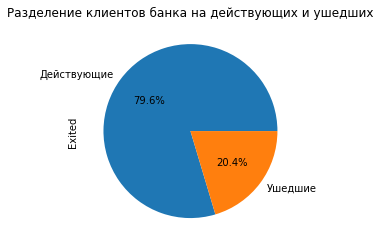

In [ ]:
# количество ушедших людей
bank_clients = bank['Exited'].value_counts()

bank_clients.plot(kind='pie', labels=['Действующие', 'Ушедшие'], autopct='%1.1f%%', 
                  title='Разделение клиентов банка на действующих и ушедших')

Более 20% клиентов европейского международного банка прекратило сотрудничество. С чем же это связано?

# Шаг 3 - Подробный анализ клиентов банка по оттоку

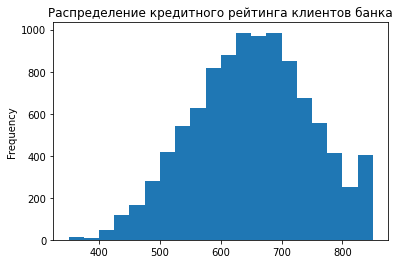

In [ ]:
# распределение кредитного рейтинга клиентов банка
bank['CreditScore'].plot(kind='hist', 
                  title='Распределение кредитного рейтинга клиентов банка', bins=20)

Большинство клиентов банка следят за уровнем кредитного рейтинга.

In [ ]:
bank_no_exited = bank[bank.Exited == 0] # оставшиеся клиенты
bank_exited = bank[bank.Exited == 1] # ушедшие клиенты

Text(0.5, 1.0, 'Сравнение распределений кредитного рейтинга в зависимости от оттока клиентов')

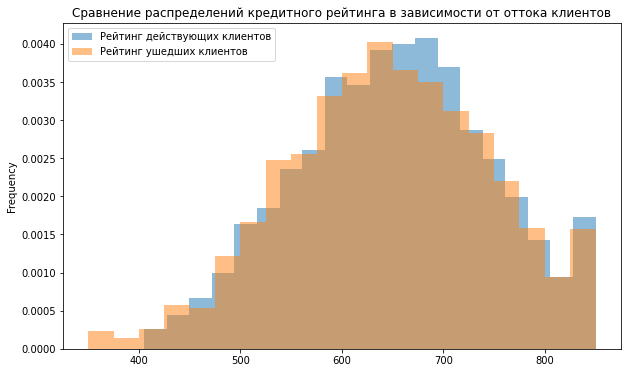

In [ ]:
# сравнение кредитных рейтингов ушедших и оставшихся клиентов банка
bank_no_exited['CreditScore'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=20,
                     density = True,
                     label='Рейтинг действующих клиентов',
                     figsize=(10, 6))

bank_exited['CreditScore'].plot(kind='hist', 
                     alpha = 0.5,
                     bins=20,
                     density = True,
                     label='Рейтинг ушедших клиентов',
                     figsize=(10, 6))

plt.legend(loc='upper left')
plt.title('Сравнение распределений кредитного рейтинга в зависимости от оттока клиентов')

Явной взаимосвязи между уходом клиента из банка и его кредитным рейтингом нет. Однако видно, что среди ушедших клиентов больше людей с самым низким кредитным рейтингом.

Клиент с кредитным рейтингом менее 400 имеет больше шансов уйти

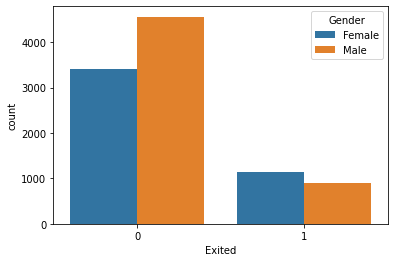

In [ ]:
# взаимосвязь половой принадлежности и оттока
sns.countplot(x='Exited', hue = 'Gender', data=bank)

Женщины покидают анализируемый банк чаще мужчин.

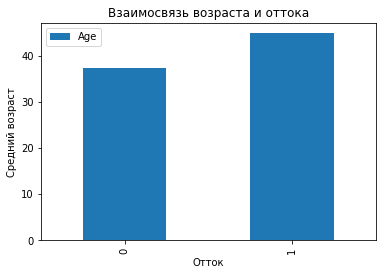

In [ ]:
# взаимосвязь возраста и оттока
avg_age_exited = bank[['Exited', 'Age']].groupby('Exited').mean().sort_values('Exited', ascending=True)
avg_age_exited.plot(kind='bar', title='Взаимосвязь возраста и оттока',
                             xlabel='Отток',
                             ylabel='Средний возраст')

In [ ]:
avg_age_exited

,Age
Exited,
0,37.408389
1,44.837997


Средний возраст клиентов покинувших банк выше, чем оставшихся клиентов.

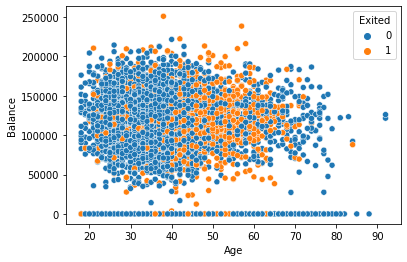

In [ ]:
sns.scatterplot(x = "Age", y = "Balance", hue = "Exited", data = bank)

Клиенты в возрасте от 40 до 70 лет имеют больше шансов уйти.

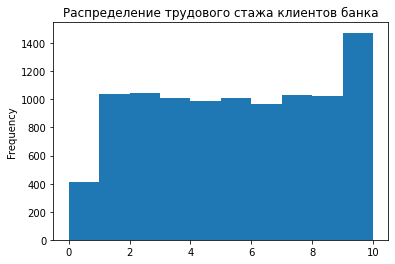

In [ ]:
# распределение трудового стажа клиентов банка
bank['Tenure'].plot(kind='hist', 
                  title='Распределение трудового стажа клиентов банка')

Text(0.5, 1.0, 'Сравнение распределений трудового стажа в зависимости от оттока клиентов')

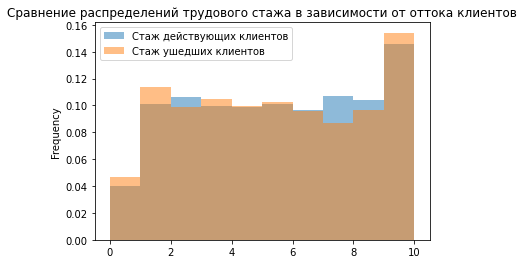

In [ ]:
bank_no_exited['Tenure'].plot(kind='hist', 
                     alpha = 0.5,
                     density = True,
                     label='Стаж действующих клиентов')

bank_exited['Tenure'].plot(kind='hist', 
                     alpha = 0.5,
                     density = True,
                     label='Стаж ушедших клиентов')
plt.legend(loc='upper left')
plt.title('Сравнение распределений трудового стажа в зависимости от оттока клиентов')

Трудовой стаж никак не влияет на отток клиентов.

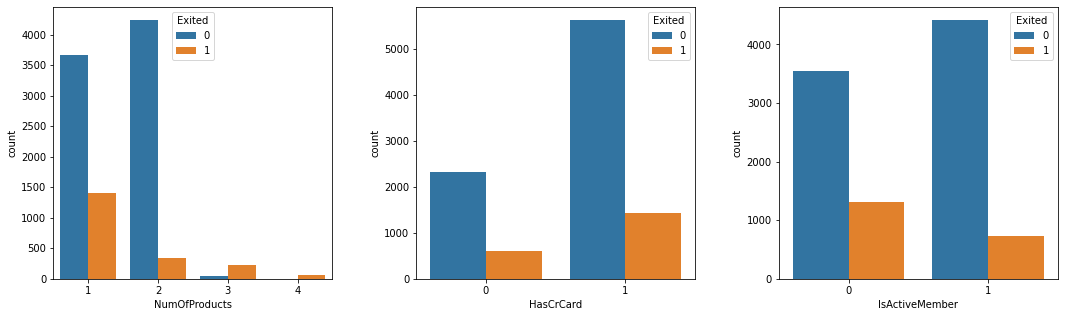

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x = 'NumOfProducts', hue='Exited', data = bank, ax= ax[0])
sns.countplot(x = 'HasCrCard', hue='Exited', data = bank, ax = ax[1])
sns.countplot(x = 'IsActiveMember', hue='Exited', data = bank, ax = ax[2])

Больше всего уходят клиенты с одним продуктом в банке. Возможно, стоит продумать более выгодные условия обслуживания, чтобы зацепить клиента. А также придумать систему лояльности клиентам, имеющих более 2-х продуктов. 

Среди ушедших людей многие из них имели кредитные карты.
Возможно, слишком жесткие условия и нужно добавить приятные бонусы владельцам кредитных карт.

Видна взаимосвязь между активностью пользователя и его уходом из банка.

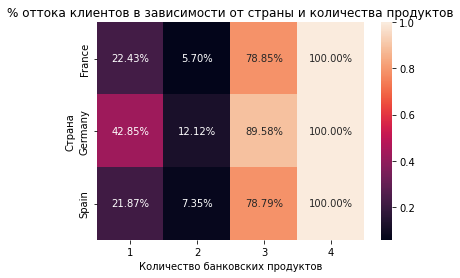

In [ ]:
bank_p1 = bank.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'mean', fill_value = 0)

plt.title('% оттока клиентов в зависимости от страны и количества продуктов')
sns.heatmap(bank_p1, annot=True, fmt='.2%')
plt.xlabel('Количество банковских продуктов') 
plt.ylabel('Страна'); 

Все клиенты с 4 продуктами вне зависимости от страны покинули банк.

Большинство клиентов с 3 продуктами покинули банк. Наибольшее количество таких клиентов зарегистрированы в Германии.

Самые лояльные пользователи имеют 2 продукта - они покидают банк меньше всего.

1/5 клиентов, имевших 1 продукт, покинули банк. Наибольшая доля таких клиентов зарегистированы в Германии.

В Германии банк теряет популярность. 

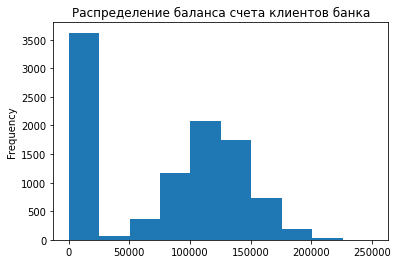

In [ ]:
# распределение баланса счета клиентов банка
bank['Balance'].plot(kind='hist', 
                  title='Распределение баланса счета клиентов банка')

Text(0.5, 1.0, 'Сравнение распределений баланса в зависимости от оттока клиентов')

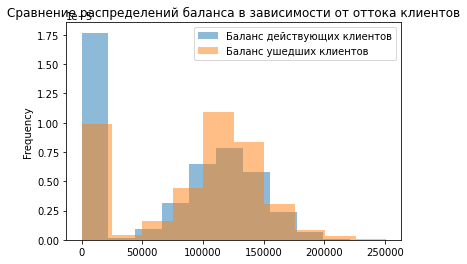

In [ ]:
bank_no_exited['Balance'].plot(kind='hist', 
                     alpha = 0.5,
                     density = True,
                     label='Баланс действующих клиентов')

bank_exited['Balance'].plot(kind='hist', 
                     alpha = 0.5,
                     density = True,
                     label='Баланс ушедших клиентов')
plt.legend(loc='upper right')
plt.title('Сравнение распределений баланса в зависимости от оттока клиентов')

Значимой взаимосвязи между оттоком клиента и его остатком на счете не выявлено.

Матрица корреляции

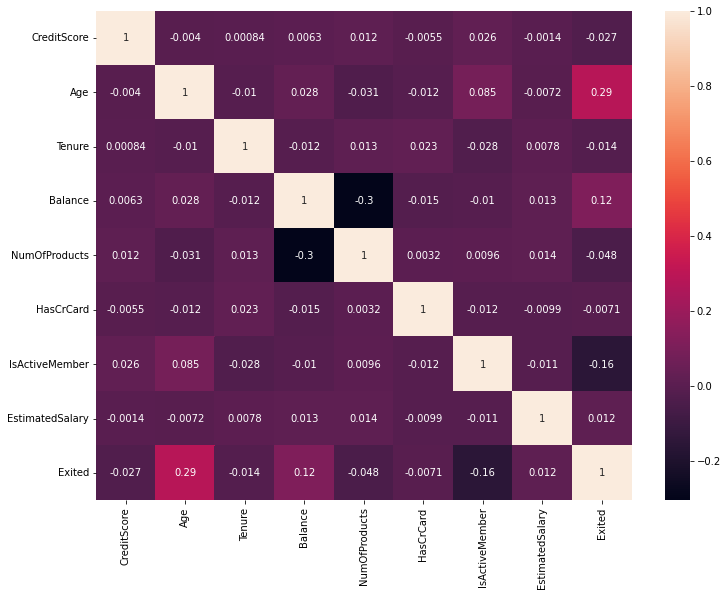

In [ ]:
plt.figure(figsize=(12, 9))
sns.heatmap(bank.corr(), annot=True)

**Выводы:** 
На отток клиента влияет его возраст и активность:
- чем старше клиент, тем вероятнее отток.
- чем менее активен клиент, тем более он подвержен риску оттока.

Также выявлено, что:
- пользователи от 40 до 70 лет в группе риска оттока.
- женщины подвержены оттоку больше мужчин.
- пользователи имеющие более 2-х продуктов чаще подвержены оттоку.
- пользователи из Германии покидают банк активнее всего.



# Шаг 4 - Проверка гипотез


**Гипотеза 1** 
- больше всего банк покидают женщины средних лет (45-59 лет)

In [ ]:
bank_female = bank[bank.Gender == 'Female'] # информация о женщинах
bank_male = bank[bank.Gender == 'Male'] # информация о мужчинах

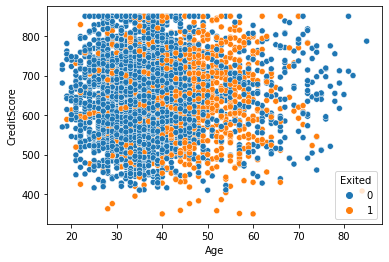

In [ ]:
# распределение оттока женщин
sns.scatterplot(x = "Age", y = "CreditScore", hue = "Exited", data = bank_female)

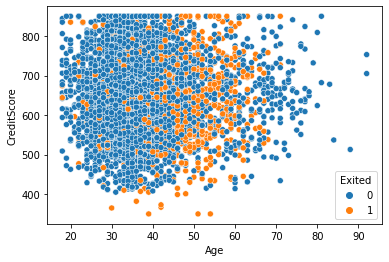

In [ ]:
# распределение оттока мужчин
sns.scatterplot(x = "Age", y = "CreditScore", hue = "Exited", data = bank_male)

In [ ]:
# выделение молодой возрастной группы (до 44 лет) среди всех клиентов банка
young_age_exited = bank[bank.Age <= 44]

# кол-во человек покинувших банк в молодой возрастной группе
young_age_exited[['Gender', 'Exited']].groupby('Gender').sum()

,Exited
Gender,
Female,552
Male,441


In [ ]:
# выделение средней возрастной группы (45-59 лет) среди всех клиентов банка
avg_age_exited = bank[(bank.Age >= 45) & (bank.Age <= 59)]

# кол-во человек покинувших банк в средней возрастной группе
avg_age_exited[['Gender', 'Exited']].groupby('Gender').sum()

,Exited
Gender,
Female,505
Male,392


In [ ]:
# выделение старшей (пожилой) возрастной группы (более 60 лет) среди всех клиентов банка
old_age_exited = bank[bank.Age >= 60]

# кол-во человек покинувших банк в старшей (пожилой) возрастной группе
old_age_exited[['Gender', 'Exited']].groupby('Gender').sum()

,Exited
Gender,
Female,82
Male,65


In [ ]:
bank_clients 

0    7963
1    2037
Name: Exited, dtype: int64

Несмотря на то, что в группе среднего возраста женщины действительно чаще покидают банк, чем мужчины - гипотеза не подтверждена.

В группе молодого возраста показатели оттока больше, поэтому наболее подвержены риску оттока молодые люди 18-44 лет, в особенности женского пола, т.к. между полами заметна значительная разница - более 100 человек.

**Гипотеза 2** 
- постоянными клиентами банка являются мужчины средних лет, имеющие кредитную карту.

In [ ]:
# сводная таблицы по полу и оттоку с заполненными значениями у тех, кто имеет кредитные карты
bank.pivot_table(index='Gender', columns='Exited', values='HasCrCard', aggfunc='sum', fill_value=0, margins=True).head()

Exited,0,1,All
Gender,,,
Female,2397,795,3192
Male,3234,629,3863
All,5631,1424,7055


In [ ]:
3234/5631*100 # доля кредитных карт у мужчин

57.43207245604688

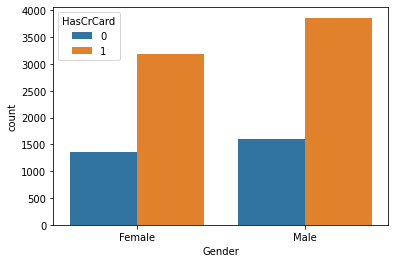

In [ ]:
# визуализация, показывающая у какого пола больше кредитных карт
sns.countplot(x='Gender', hue = 'HasCrCard', data = bank)

Более 70% банка имеют кредитные карты. 

Среди действующих клиентов больше всего кредитных карт у мужчин (57,43%).

In [ ]:
# наличие кредитной карты среди молодой возрастной группы
young_age_exited.pivot_table(index='Gender', columns='Exited', values='HasCrCard', aggfunc='sum', fill_value=0).head()

Exited,0,1
Gender,,
Female,1990,398
Male,2727,309


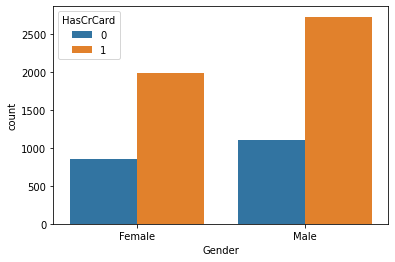

In [ ]:
sns.countplot(x='Gender', hue = 'HasCrCard', data = young_age_exited[young_age_exited.Exited == 0])

In [ ]:
# наличие кредитной карты среди средней возрастной группы
avg_age_exited.pivot_table(index='Gender', columns='Exited', values='HasCrCard', aggfunc='sum', fill_value=0).head()

Exited,0,1
Gender,,
Female,292,341
Male,353,272


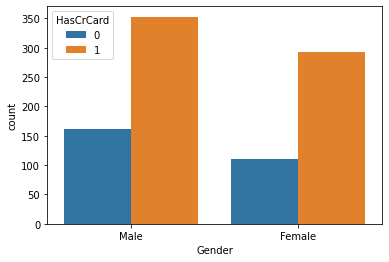

In [ ]:
sns.countplot(x='Gender', hue = 'HasCrCard', data = avg_age_exited[avg_age_exited.Exited == 0])

In [ ]:
# наличие кредитной карты среди старшей (пожилой) возрастной группы
old_age_exited.pivot_table(index='Gender', columns='Exited', values='HasCrCard', aggfunc='sum', fill_value=0).head()

Exited,0,1
Gender,,
Female,115,56
Male,154,48


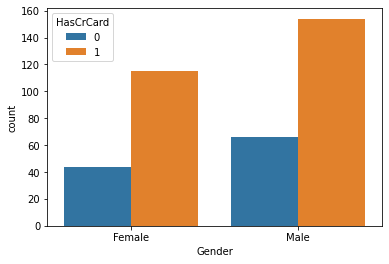

In [ ]:
sns.countplot(x='Gender', hue = 'HasCrCard', data = old_age_exited[old_age_exited.Exited == 0])

Гипотеза не подтвердилась. У мужчин действительно чаще имеется кредитная карта, но наибольшей популярностью они пользуются среди молодого поколения, в особенности у мужчин - это наиболее большая по численности группа 2727 человек.

**Гипотеза 3**
- чаще всего банк покидают люди среднего возраста, вне зависимости от количества банковских продуктов и страны регистрации.

In [ ]:
# распределение всех людей по разным странам и количеству продуктов
bank.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'count', fill_value = 0, margins=True)

NumOfProducts,1,2,3,4,All
Geography,,,,,
France,2514,2367,104,29,5014
Germany,1349,1040,96,24,2509
Spain,1221,1183,66,7,2477
All,5084,4590,266,60,10000


In [ ]:
# распределение ушедших людей по разным странам и количеству продуктов
bank.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'sum', fill_value = 0, margins=True)

NumOfProducts,1,2,3,4,All
Geography,,,,,
France,564,135,82,29,810
Germany,578,126,86,24,814
Spain,267,87,52,7,413
All,1409,348,220,60,2037


In [ ]:
# % оттока пользователей по странам
print(f'Отток пользователей во Франции {810/5014*100}')
print(f'Отток пользователей в Германии {814/2509*100}')
print(f'Отток пользователей в Испании {413/2477*100}')

Отток пользователей во Франции 16.15476665337056
Отток пользователей в Германии 32.44320446392985
Отток пользователей в Испании 16.673395236172787


In [ ]:
# распределение людей молодой возрастной группы по оттоку и количеству продуктов
young_age_exited.pivot_table(index='NumOfProducts', columns='Exited', values='HasCrCard', aggfunc='count', fill_value=0, margins=True).head()

Exited,0,1,All
NumOfProducts,,,
1,3043,667,3710
2,3583,183,3766
3,41,116,157
4,0,27,27
All,6667,993,7660


In [ ]:
993/7660*100

12.963446475195822

Около 13% клиентов банка в молодой возрастной группе покинули банк.

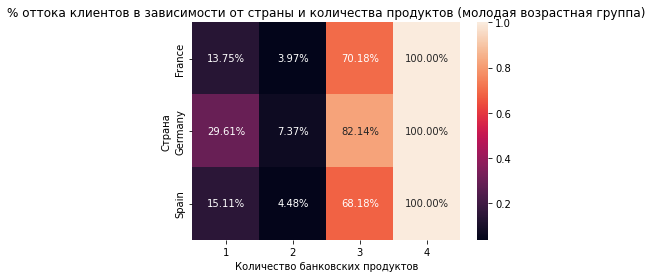

In [ ]:
age1 = young_age_exited.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'mean', fill_value = 0)

plt.title('% оттока клиентов в зависимости от страны и количества продуктов (молодая возрастная группа)')
sns.heatmap(age1, annot=True, fmt='.2%')
plt.xlabel('Количество банковских продуктов') 
plt.ylabel('Страна'); 

Вывод по молодой возрастной группе:
- все пользователи, имевшие 4 банковских продукта вне зависимости от страны покинули банк.
- около 70% пользователей из Франции и Испании покинули банк при наличии трех продуктов. Более 80% пользователей из Германии покинули банк имея 3 продукта.
- наименьший отток был среди пользователей с 2 продуктами: менее 5% пользователей из Франции и Испании, и менее 8% из Германии.
- около 15% аудитории из Франции и Испании покинуло банк имея 1 продукт. В Германии этот показатель составил 30%.

In [ ]:
# распределение людей средней возрастной группы по оттоку и количеству продуктов
avg_age_exited.pivot_table(index='NumOfProducts', columns='Exited', values='HasCrCard', aggfunc='count', fill_value=0, margins=True).head()

Exited,0,1,All
NumOfProducts,,,
1,446,643,1089
2,470,136,606
3,1,89,90
4,0,29,29
All,917,897,1814


In [ ]:
897/1814*100

49.44873208379272

49% клиентов банка в средней возрастной категории покинуло банк.

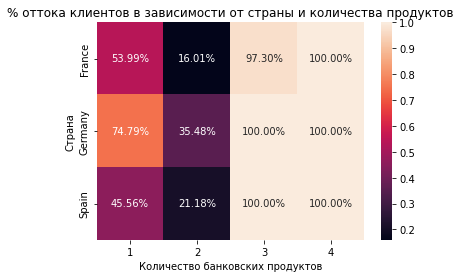

In [ ]:
age2 = avg_age_exited.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'mean', fill_value = 0)

plt.title('% оттока клиентов в зависимости от страны и количества продуктов')
sns.heatmap(age2, annot=True, fmt='.2%')
plt.xlabel('Количество банковских продуктов') 
plt.ylabel('Страна'); 

Вывод по средней возрастной группе:
- все пользователи, имевшие 4 банковских продукта вне зависимости от страны покинули банк.
- почти все пользователей вне зависимости от страны покинули банк при наличии трех продуктов. Небольшой процент пользователей из Франции продолжает пользоваться 3 продуктами банка (2,7%)
- достаточно активно покидают банк пользователи с 2 продуктами.
- еще более активно покидают банк с 1 продуктом: более 45% в Испании, около 54% во Франции, "рекорд" оттока в Германии составил около 75%.

In [ ]:
# распределение людей старшей (пожилой) возрастной группы по оттоку и количеству продуктов
old_age_exited.pivot_table(index='NumOfProducts', columns='Exited', values='HasCrCard', aggfunc='count', fill_value=0, margins=True).head()

Exited,0,1,All
NumOfProducts,,,
1,186,99,285
2,189,29,218
3,4,15,19
4,0,4,4
All,379,147,526


In [ ]:
147/526*100

27.9467680608365

около 28% клиентов банка в старшей пожилой возрастной категории покинуло банк.

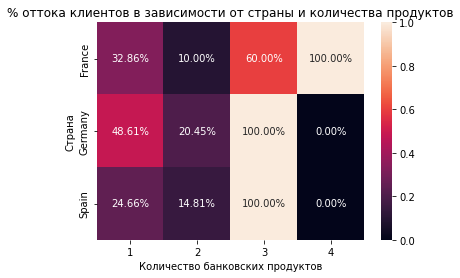

In [ ]:
age3 = old_age_exited.pivot_table(index = 'Geography', columns = 'NumOfProducts', values = 'Exited', aggfunc = 'mean', fill_value = 0)

plt.title('% оттока клиентов в зависимости от страны и количества продуктов')
sns.heatmap(age3, annot=True, fmt='.2%')
plt.xlabel('Количество банковских продуктов') 
plt.ylabel('Страна'); 

Вывод по старшей (пожилой) возрастной группе:
- в таких странах, как Германия и Испания вовсе не было пользователей за 60 лет, которые пользуются 4 продуктами. Все пользователи из Франции с 4 продуктами покинули банк.
- все пользователей из Германии и Испании покинули банк при наличии трех продуктов. 40% пользователей из Франции продолжает пользоваться 3 продуктами банка.
- достаточно активно покидают банк пользователи с 2 продуктами. Наибольший процент оттока в Германии (более 20%)
- пользователи Испании, имея 1 продукт покидают банк почти в 25% случая, пользователи во Франции почти в 33% случаях, пользователи в Германии почти в 50% случаев.

Гипотеза подтверждена. 

Люди среднего возраста действительно чаще всего покидают банк.
У них наиболее высокие показатели оттока, вне зависимости от количества продуктов и страны регистрации. 

# Шаг 5 - Построение модели оттока клиентов банка

In [ ]:
# подготовка данных для прогнозирования

# заменяем слово на идентификатор
bank['Gender'].replace(['Male', 'Female'], [0, 1], inplace=True)
bank['Geography'].replace(['France', 'Germany', 'Spain'], [1, 2, 3], inplace=True)

Перед нами стоит задача классификации элементов в две группы (предсказание, какой из групп принадлежит каждый элемент) на основе правила классификации. По-другому это называется бинарная классификация. 

Для решения данной задачи использовались  "Логистическая регрессия", "Рандомный лес", "Градиентный бустинг".

In [ ]:
# разделение данных на обучающие и тестовые
X = bank.drop("Exited", axis=1)
y = bank['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
# импорт моделей для предсказания

# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_1 = LogisticRegression(random_state = 25)

# Random Forrest
from sklearn.ensemble import RandomForestClassifier
model_2 = RandomForestClassifier(n_estimators = 50, random_state = 25)

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
model_3 = GradientBoostingClassifier(random_state = 25)

In [ ]:
# проводим обучение модели и записываем результаты проверки качества предсказания

model = [model_1, model_2, model_3]
accuracy = []

for i in model:
  i.fit(X_train, y_train)  # обучаем модель

  ac_sc = accuracy_score(y_test, i.predict(X_test)) # расчет точности
  accuracy.append(ac_sc)

In [ ]:
# выводим готовый результат в виде таблицы

models = pd.DataFrame({'Model':['Logistic Regression', 'RandomForestClassifier', 'GradientBoostingClassifier'],
              'accuracy_score': accuracy,
              })

models

,Model,accuracy_score
0,Logistic Regression,0.7880
1,RandomForestClassifier,0.8600
2,GradientBoostingClassifier,0.8625


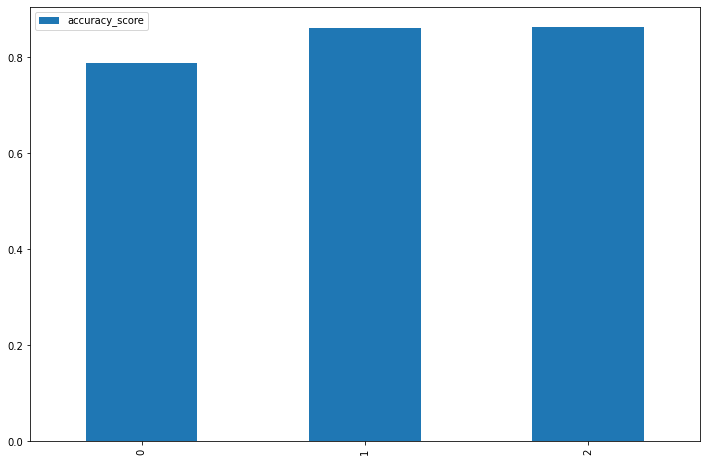

In [ ]:
# визуальное отображение метрик качества
models.plot(kind='bar', figsize=(12, 8))

Наиболее хорошие результаты показали, такие модели как:
- RandomForestClassifier -  точность предсказания 86%
- GradientBoostingClassifier - точность предсказания 86,25%

Лидирующая модель прогнозирования это GradientBoostingClassifier, т.к. она показала наибольшую точность предсказания.

# Результаты проведенного анализа, рекомендации и мероприятия по улучшению представлены в [презентации](https://drive.google.com/file/d/1bQlCYvSeabqV814tOHktkJTm1bdefhlb/view?usp=sharing).